In [ ]:
%%capture
!pip3 install daam
!pip install diffusers
!pip3 install ftfy
!pip3 install transformers
!pip3 install accelerate

In [ ]:
import os
import shutil
import json
import torch
from diffusers import StableDiffusionPipeline
from typing import Any, Optional, Tuple, Union
import numpy as np
import torch
import random
import torch.nn.functional as F
from tqdm import tqdm
import math
import random
from transformers import CLIPTextModel, CLIPTokenizer
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import daam

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# %%shell
# unzip Noto_Emoji.zip
# mkdir -p ~/.fonts
# cp *.ttf ~/.fonts
# fc-cache -f -v

In [ ]:
# !fc-list

In [ ]:
# from matplotlib.font_manager import findfont, FontProperties

# # Font name to search for
# font_name = "Noto Emoji"

# # Find the path of the font file
# # font_path = findfont(FontProperties(family=font_name))
# font_path = findfont(font_name)

# # Print the path of the font file
# print("Path of", font_name, "font:", font_path)

Path of Noto Emoji font: /root/.fonts/NotoEmoji-VariableFont_wght.ttf


In [ ]:
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Noto Emoji']
# plt.rcParams['axes.unicode_minus'] = False

In [ ]:
model_id = "runwayml/stable-diffusion-v1-5"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker = None)
pipe = pipe.to(device)
pipe.enable_attention_slicing()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [42]:
plt.rcParams['figure.figsize'] = (22,8)

def set_seed(seed):
  gen = torch.Generator(device=device)
  random.seed(seed)
  np.random.seed(seed)
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

  return gen.manual_seed(seed)

def make_im_subplots(*args):
  fig, ax = plt.subplots(*args)

  for ax_ in ax.flatten():
    ax_.set_xticks([])
    ax_.set_yticks([])

  return fig, ax


def view_image(heatmaps, original_img):
  num_imgs = len(heatmaps)+1
  fig, axes = make_im_subplots(1,num_imgs)
  axes[0].imshow(original_img)

  cnt = 1
  for i in range(num_imgs):
    if i == 0:
      continue
    else:
      heatmaps[cnt-1].plot_overlay(original_img, ax=axes[i])
      cnt = cnt + 1

  plt.tight_layout()
  plt.show()


def show_image(heatmaps, original_img, instruction):

  if instruction == "before":
    view_image(heatmaps, original_img)
    return

  num_imgs = len(heatmaps) + 1
  cols = 8
  rows = num_imgs//cols
  if rows*cols != num_imgs:
    rows += 1

  fig, axes = plt.subplots(nrows=rows, ncols = cols, squeeze=False)

  for ax_ in axes.flatten():
    ax_.set_xticks([])
    ax_.set_yticks([])

  for i in range(rows):
    for j in range(cols):
      axes[i, j].set_axis_off()

  axes[0, 0].set_axis_on()
  axes[0, 0].imshow(original_img)

  cnt = 1
  for i in range(rows):
    for j in range(cols):
      if i == 0 and j == 0:
        continue
      if cnt >= num_imgs:
        break
      else:
        axes[i, j].set_axis_on()
        heatmaps[cnt-1].plot_overlay(original_img, ax=axes[i, j])
        cnt = cnt + 1

  plt.tight_layout()
  plt.show()

In [ ]:
def text_image_cross_attention(prompt, seed, instruction):
  gen = set_seed(seed)  # for reproducibility

  with torch.no_grad():
      with daam.trace(pipe) as tc:
          out = pipe(prompt, num_inference_steps=50, generator=gen).images[0]
          heat_map = tc.compute_global_heat_map()
      wordlist = prompt.split()
      maplist = []
      for word in wordlist:
        map = heat_map.compute_word_heat_map(word)
        maplist.append(map)
      show_image(maplist, out, instruction)

In [ ]:
def word_image_cross_attention(prompt, inp_word, seed):
    gen = set_seed(seed)  # for reproducibility
    with torch.no_grad():
        with daam.trace(pipe) as tc:
            out = pipe(prompt, num_inference_steps=50, generator=gen).images[0]
            heat_map = tc.compute_global_heat_map()
        input_map = heat_map.compute_word_heat_map(inp_word)

        plt.rcParams['figure.figsize'] = (8, 4)
        fig, ax = make_im_subplots(1, 2)

        # Original image
        ax[0].imshow(out)
        input_map.plot_overlay(out, ax=ax[1])
        plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

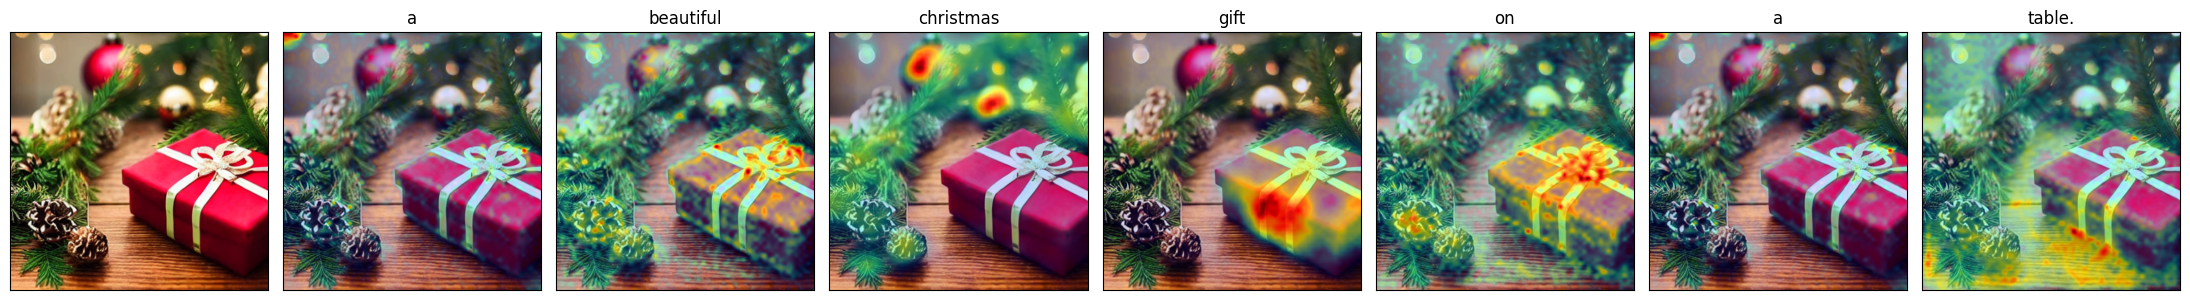

In [43]:
text_image_cross_attention("a beautiful christmas gift on a table.", 4, "before")

  0%|          | 0/50 [00:00<?, ?it/s]

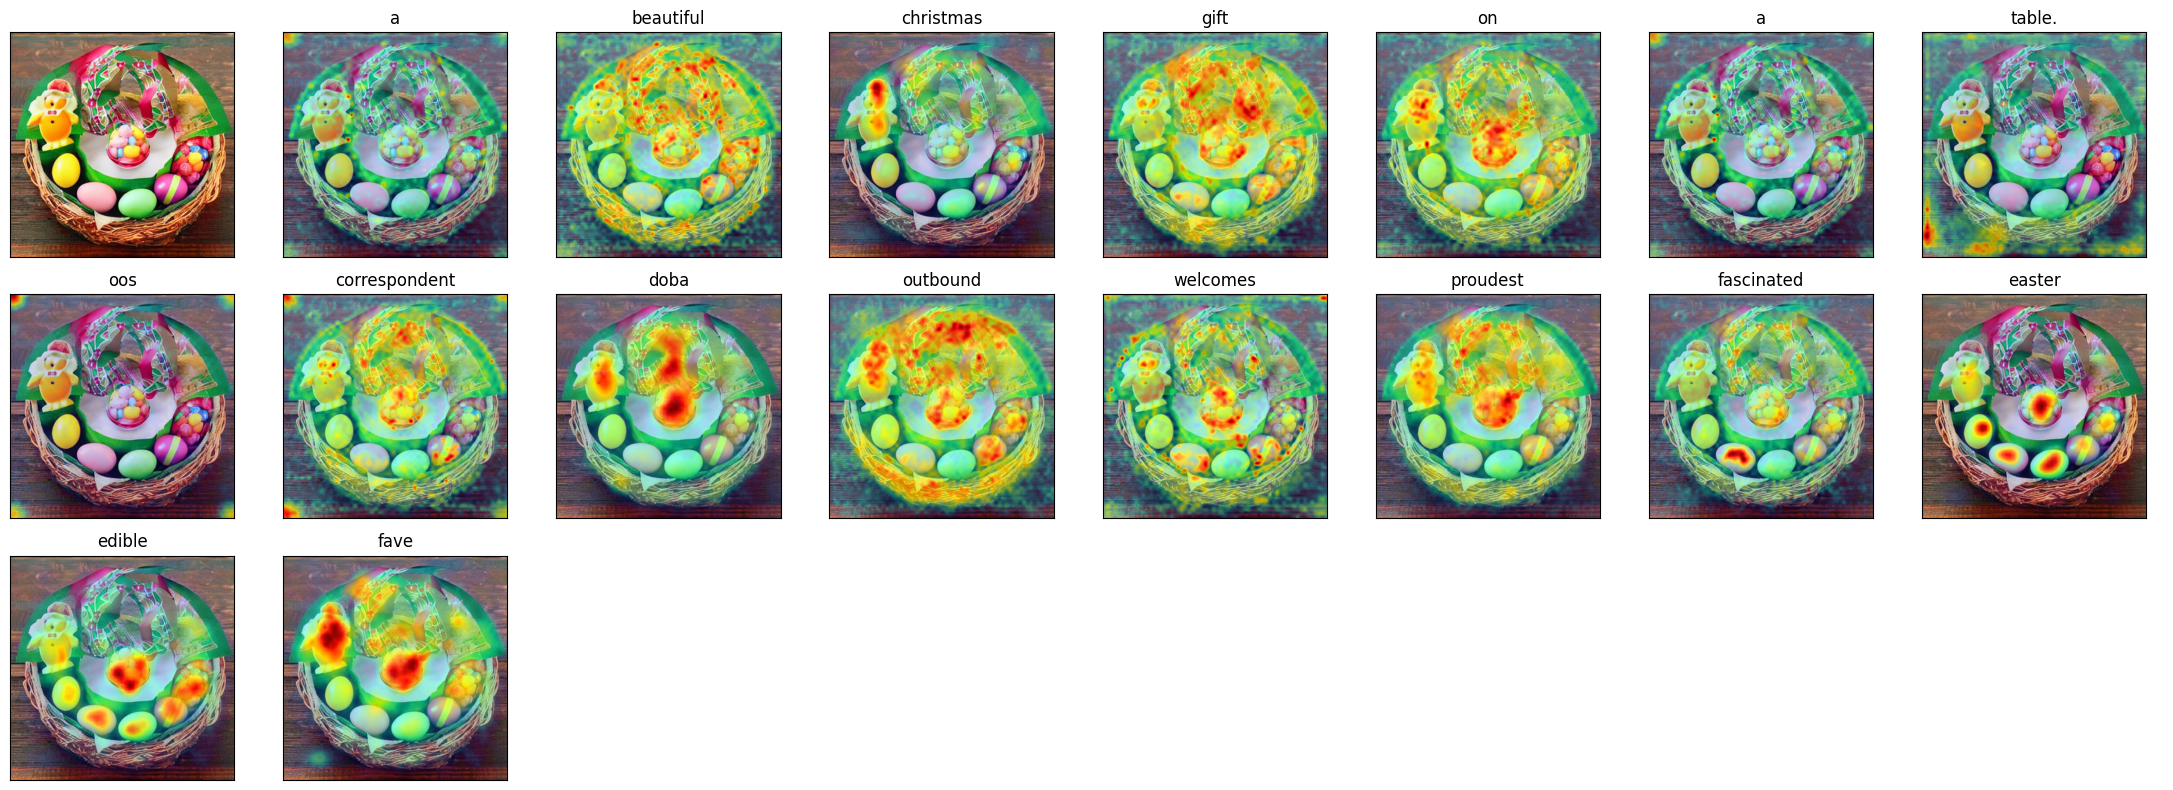

In [44]:
text_image_cross_attention("a beautiful christmas gift on a table. oos correspondent doba outbound welcomes proudest fascinated easter edible fave", 4, "after")

  0%|          | 0/50 [00:00<?, ?it/s]

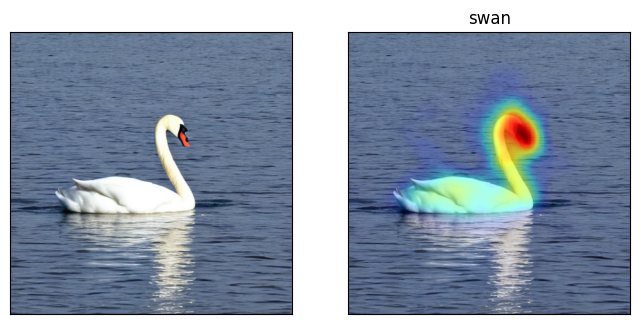

In [ ]:
word_image_cross_attention("a white swan on a lake.", "swan",216)

  0%|          | 0/50 [00:00<?, ?it/s]

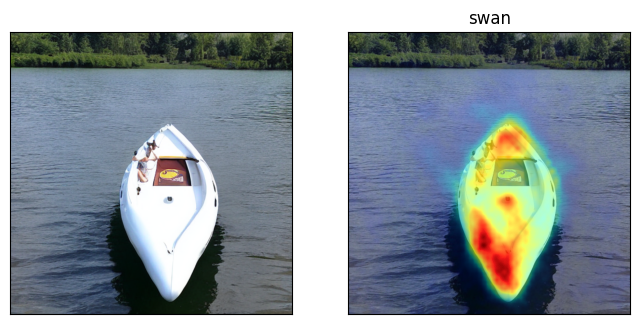

In [ ]:
word_image_cross_attention("a white swan on a lake. mondaymotivaton boat of -->> jaifundraising dory lifts consul sportscar", "swan",216)